In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 


2024-03-23 17:14:40.938013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_DIR = "PokerDataset"  
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

In [3]:
image_paths = []
labels = []


In [4]:
for label in os.listdir(DATA_DIR):
    label_dir = os.path.join(DATA_DIR, label)
    for image_file in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, image_file))
        labels.append(label)

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=TEST_SIZE, random_state=42, stratify=labels)

In [6]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_val)
y_train_val_encoded = label_encoder.transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Convert integer labels to categorical format
y_train_val = to_categorical(y_train_val_encoded, NUM_CLASSES)

# Convert integer labels to categorical format
y_test = to_categorical(y_test_encoded, NUM_CLASSES)

In [8]:
# Verify one-hot encoding
print("Shape of y_train_val:", y_train_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train_val: (624, 52)
Shape of y_test: (156, 52)


In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

In [10]:
X_train_val = [preprocess_image(image_path) for image_path in X_train_val]
X_test = [preprocess_image(image_path) for image_path in X_test]

In [11]:
X_train_val = np.array(X_train_val)
X_test = np.array(X_test)

In [12]:
# Save the preprocessed data
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', label_encoder.classes_)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks


In [15]:
model = Sequential()
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32, activation='relu', name='dense1'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))




print("Model summary:")
model.summary()

Model summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 4)         112       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 8)         296       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense1 (Dense)              (None, 32)                50208     
                                                                 
 output (Dense)              (None, 52)

In [16]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/50
44/47 [===========================>..] - ETA: 0s - loss: 3.9800 - accuracy: 0.0136
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 3.95306, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 3.95306, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 2s 20ms/step - loss: 3.9783 - accuracy: 0.0128 - val_loss: 3.9531 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 3.9548 - accuracy: 0.0321
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss did not improve from 3.95306

Epoch 2: val_loss did not improve from 3.95306

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_mod

Epoch 14/50
42/47 [=========================>....] - ETA: 0s - loss: 0.6831 - accuracy: 0.8095
***callbacks***
saving losses to model_1/losses.log

Epoch 14: val_loss improved from 2.82035 to 2.76587, saving model to model_1/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 2.82035 to 2.76587, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_1/KERAS_check_model_last.h5

Epoch 14: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 0.6904 - accuracy: 0.8056 - val_loss: 2.7659 - val_accuracy: 0.3910 - lr: 0.0010
Epoch 15/50
47/47 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.8590
***callbacks***
saving losses to model_1/losses.log

Epoch 15: val_loss did not improve from 2.76587

Epoch 15: val_loss did not improve from 2.76587

Epoch 15: saving model to model_1/KERAS_check_model_last.h5

Epoch 15: saving model to model_1/K


***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 3.5829 - val_accuracy: 0.5256 - lr: 5.0000e-04
Epoch 29/50
43/47 [==========================>...] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 29: val_loss did not improve from 2.76587

Epoch 29: val_loss did not improve from 2.76587

Epoch 29: saving model to model_1/KERAS_check_model_last.h5

Epoch 29: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 3.6379 - val_accuracy: 0.5192 - lr: 5.0000e-04
Epoch 30/50
43/47 [==========================>...] - ETA: 0s - loss: 0.0153 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 30: val_loss did not improve from 2.76587

Epoch 30: val_loss did not improve from 2.76587

Epoch 30: saving model to model_1/KERAS_c


Epoch 43: saving model to model_1/KERAS_check_model_last.h5

Epoch 43: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 3.9287 - val_accuracy: 0.5385 - lr: 2.5000e-04
Epoch 44/50
42/47 [=========================>....] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 44: val_loss did not improve from 2.76587

Epoch 44: val_loss did not improve from 2.76587

Epoch 44: saving model to model_1/KERAS_check_model_last.h5

Epoch 44: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 3.9442 - val_accuracy: 0.5321 - lr: 2.5000e-04
Epoch 45/50
47/47 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 45:

5/5 [==============================] - 0s 13ms/step
Accuracy: 0.5256410256410257


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

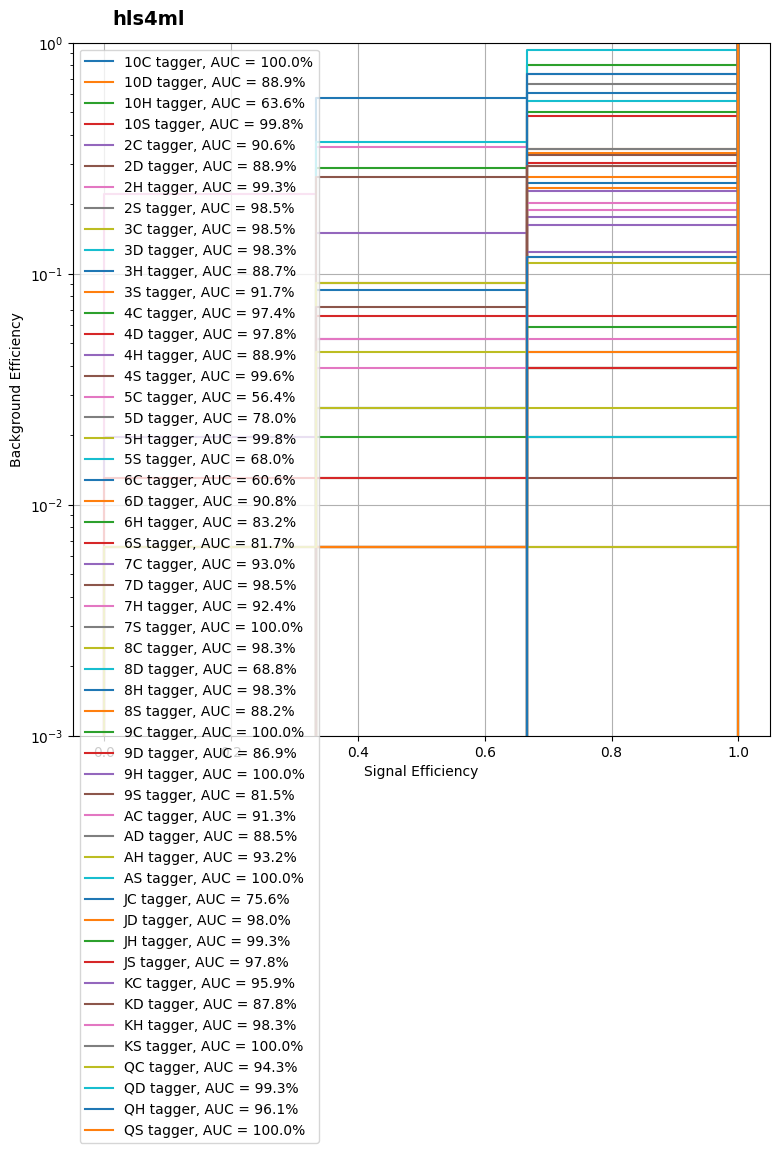

In [22]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)

In [23]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Stra

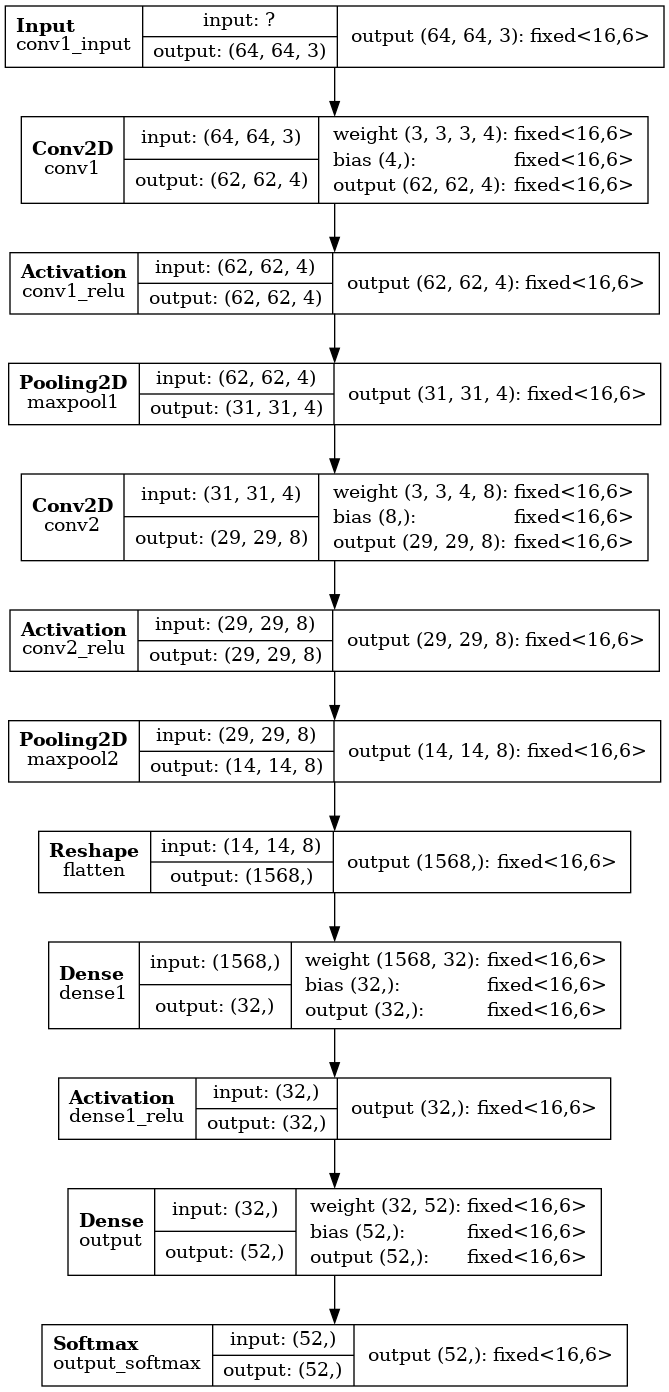

In [24]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)


In [25]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))


Writing HLS project
Done
Keras  Accuracy: 0.5256410256410257
hls4ml Accuracy: 0.17307692307692307


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

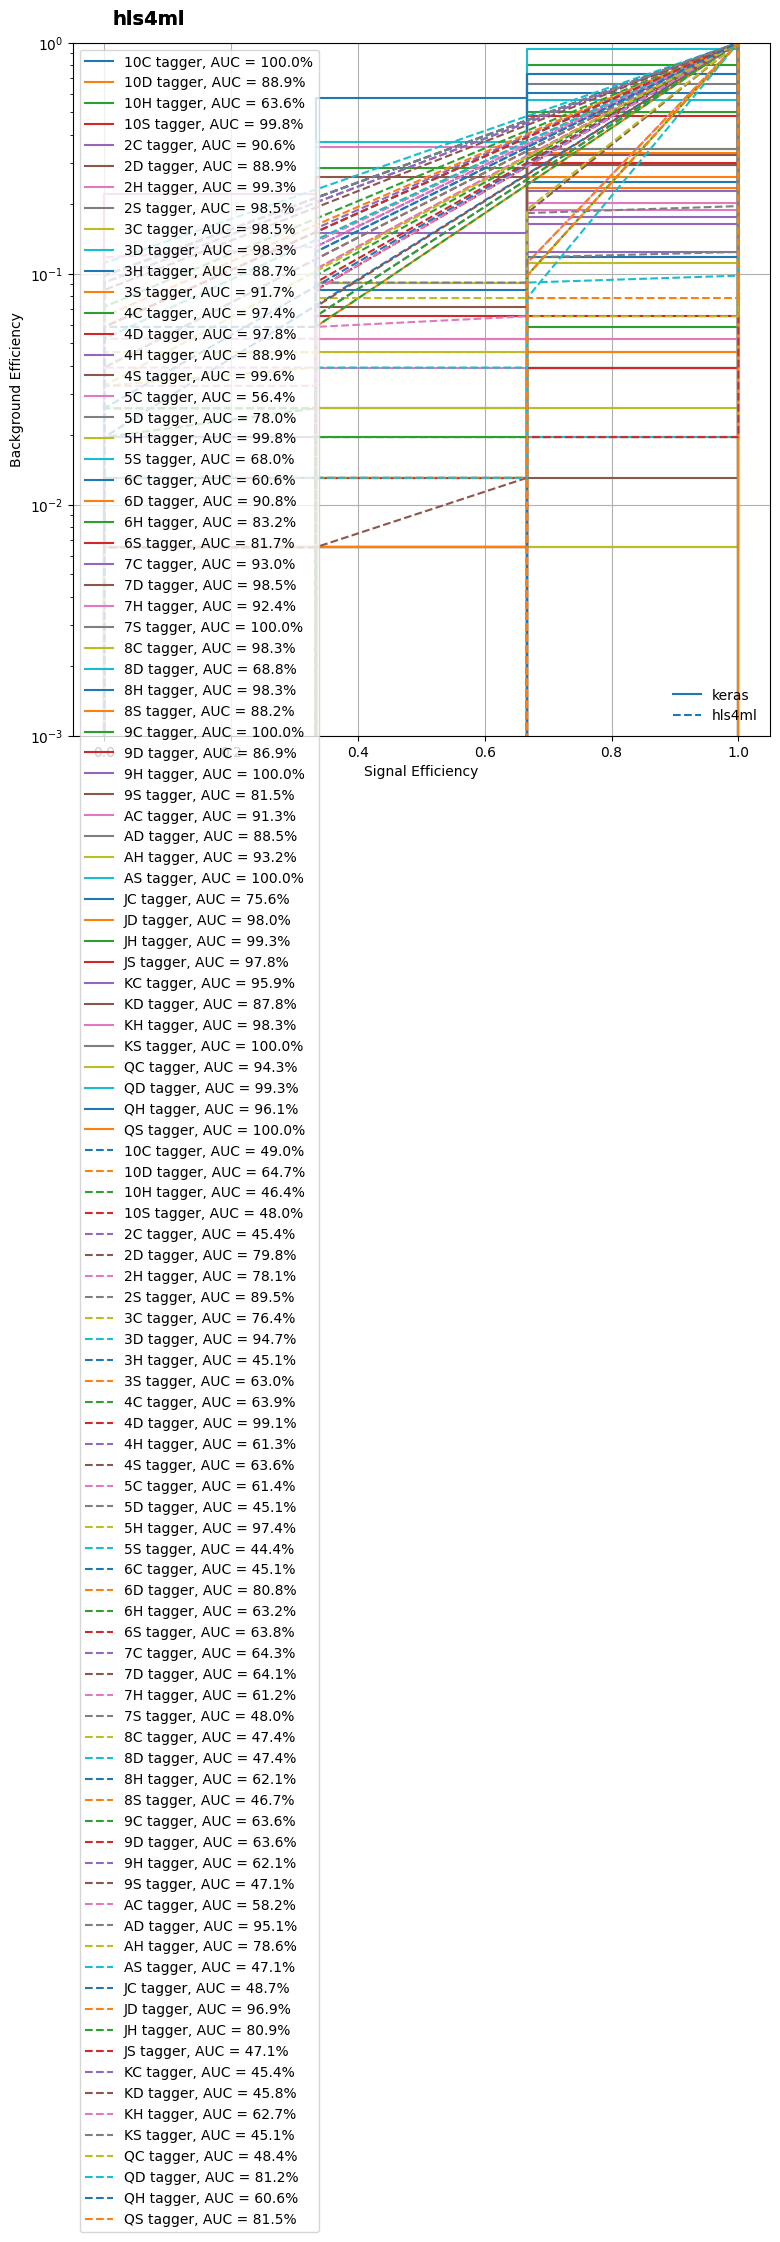

In [26]:
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, label_encoder.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

Quantization Model

In [27]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [28]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

In [30]:
model = Sequential()
model.add(Conv2D(4, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), name='conv2'))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32,name='dense1'))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [33]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    

else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_2/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/50
44/47 [===========================>..] - ETA: 0s - loss: 3.9603 - accuracy: 0.0182
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 3.95154, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 3.95154, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 2s 27ms/step - loss: 3.9588 - accuracy: 0.0192 - val_loss: 3.9515 - val_accuracy: 0.0128 - lr: 0.0010
Epoch 2/50
44/47 [===========================>..] - ETA: 0s - loss: 3.9238 - accuracy: 0.0432
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 3.95154 to 3.93193, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 3.95154 to 3.93193, saving model to model_2/KERAS_check_best_model_weight


Epoch 13: saving model to model_2/KERAS_check_model_last.h5

Epoch 13: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 2.0359 - accuracy: 0.8718 - val_loss: 2.7308 - val_accuracy: 0.3910 - lr: 0.0010
Epoch 14/50
45/47 [===========================>..] - ETA: 0s - loss: 1.9204 - accuracy: 0.8933
***callbacks***
saving losses to model_2/losses.log

Epoch 14: val_loss improved from 2.73076 to 2.67108, saving model to model_2/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 2.73076 to 2.67108, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_2/KERAS_check_model_last.h5

Epoch 14: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 1.9130 - accuracy: 0.8910 - val_loss: 2.6711 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 15/50
46/47 [============================

Epoch 26/50
46/47 [============================>.] - ETA: 0s - loss: 0.8199 - accuracy: 0.9804
***callbacks***
saving losses to model_2/losses.log

Epoch 26: val_loss improved from 2.05527 to 2.00441, saving model to model_2/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 2.05527 to 2.00441, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_2/KERAS_check_model_last.h5

Epoch 26: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 0.8227 - accuracy: 0.9808 - val_loss: 2.0044 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 27/50
46/47 [============================>.] - ETA: 0s - loss: 0.7718 - accuracy: 0.9848
***callbacks***
saving losses to model_2/losses.log

Epoch 27: val_loss improved from 2.00441 to 1.98844, saving model to model_2/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 2.00441 to 1.98844, saving model to model_2/KERAS_check_b


Epoch 38: saving model to model_2/KERAS_check_model_last.h5

Epoch 38: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 17ms/step - loss: 0.3899 - accuracy: 0.9915 - val_loss: 1.7177 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 39/50
46/47 [============================>.] - ETA: 0s - loss: 0.3713 - accuracy: 0.9913
***callbacks***
saving losses to model_2/losses.log

Epoch 39: val_loss improved from 1.70679 to 1.69082, saving model to model_2/KERAS_check_best_model.h5

Epoch 39: val_loss improved from 1.70679 to 1.69082, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 39: saving model to model_2/KERAS_check_model_last.h5

Epoch 39: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 0.3710 - accuracy: 0.9915 - val_loss: 1.6908 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 40/50
45/47 [===========================>

In [34]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_2/y_qkeras.npy', y_qkeras)
np.save('model_2/y_hls.npy', y_hls)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: relu2, layer type: Activation, input shapes: [[None, 29, 29, 8]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [

5/5 [==============================] - 0s 11ms/step
Accuracy baseline:  0.40384615384615385
Accuracy quantized: 0.5833333333333334
Accuracy hls4ml: 0.5705128205128205


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

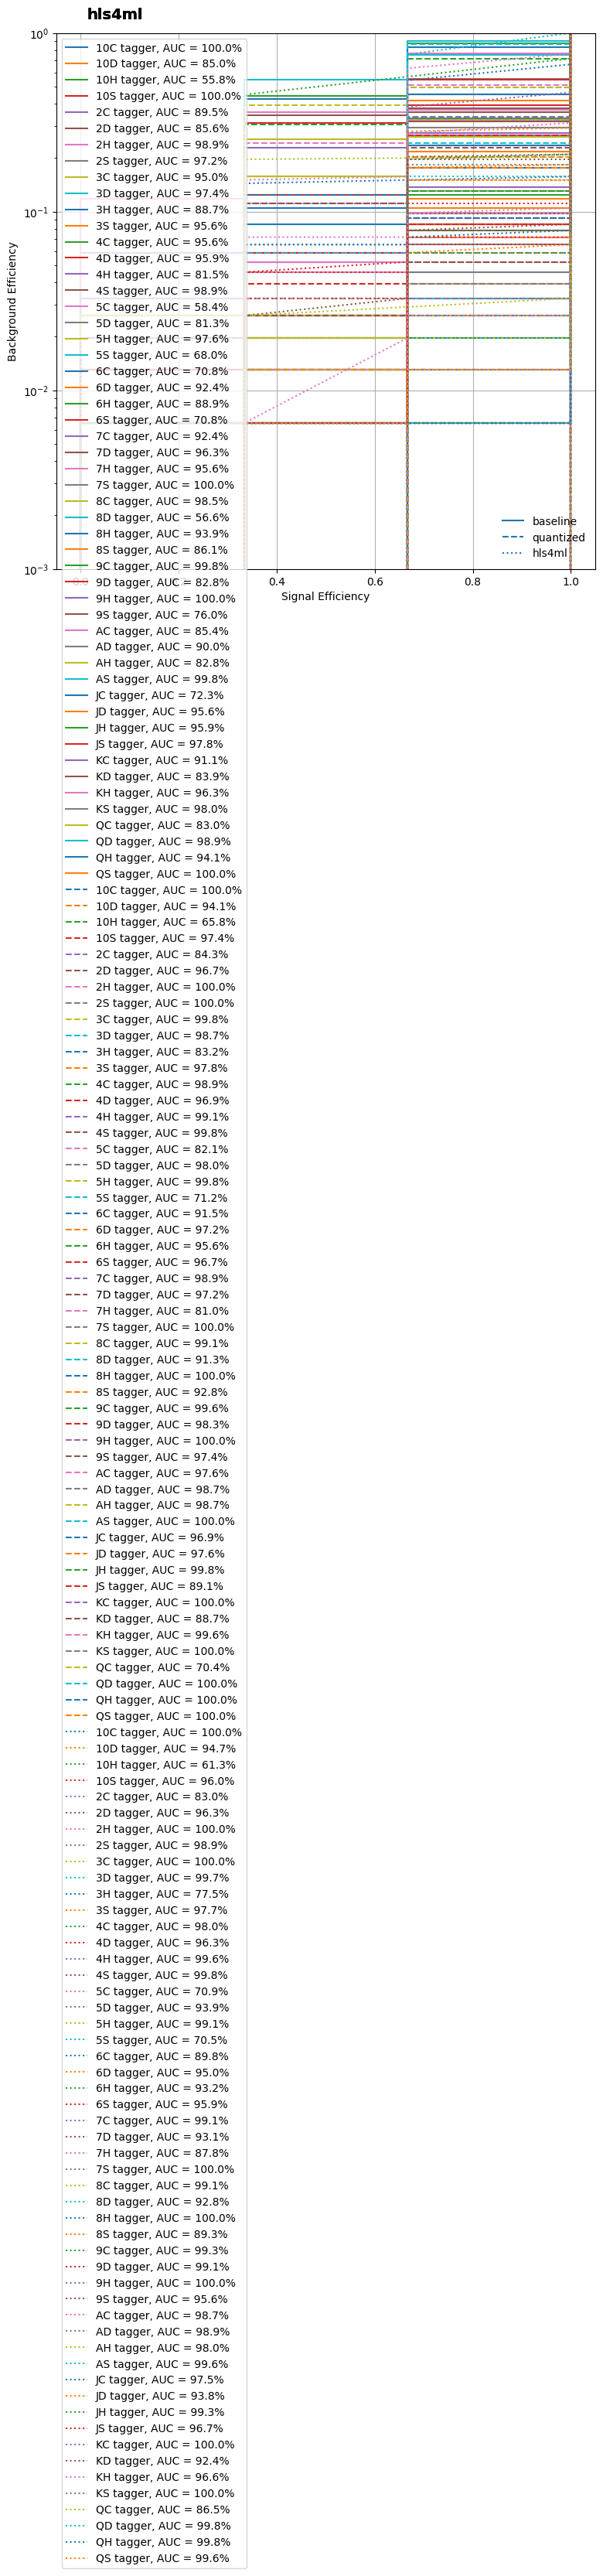

In [35]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)